# DATA ANALYSIS

## Intro (NER)
The idea behind this study is to extract named entity by given an input text. <br>
**Example:** <br>
outdoor collection ballerines toile corail blanc 40 <br>
outdoor collection => brand<br>
ballerines toile   => object<br>
blanc              => colour<br>
corail             => clour<br>
40                 => details<br>

## Libraries

In [87]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
import warnings
display(HTML("<style>.container { width:90% !important; }</style>"))
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import tags as tg
import numpy as np
import time
from collections.abc import Iterable
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('seaborn-notebook')
t = time.time()

## Functions definition

In [3]:
def calcul_nan(df,columns):
    my_dic = {}
    for col in columns:
        my_dic[col]= df[df[col].isna()].shape[0]
    return my_dic

In [4]:
def extract_tags(df,tags):
    result = {}
    for tag in tags:  
        sub_list = []
        for element in df[tag]:
            if (element and isinstance(element, list)):
                for sub_element in element:
                    sub_list.append(sub_element)
        result[tag] = list(set(sub_list))
    return result

In [5]:
def extract_tags2(df,tags):
    result = {}
    for tag in tags:  
        sub_list = []
        if (isinstance(df[tag],list)):
            for element in df[tag]:
                sub_list.append(element)
        result[tag] = list(set(sub_list))
    return result

In [6]:
def pos_calc(sentence,search_str,tag):

    sentence = sentence.lstrip()
    search_str = search_str.lstrip()

    data  = []
    start = 0
    end   = len(sentence)
    truth = True

    Is = 0
    Ie = 0
    s  = 0 
    while (truth):
        truth = False

        if (search_str in sentence[start:end]):

            truth = True
            s = sentence[start:end].index(search_str)
            Is = sentence[start:start+s].count(" ")+Ie
            Ie = search_str.count(" ") + Is
            data.append((Is,Ie,search_str,tag))
            start += len(search_str) + len(sentence[start:start+s])

    return data


In [7]:
def pos_tag(sentence,data):

    sentence = sentence.lstrip()
    sentence = sentence.split(" ")

    
    tags = [(str(word),"O") for word in sentence]
    if(len(data)>0):
        for element in data:
            search = element[2].split(" ")
            j=0
            
            tags[element[0]] = (search[0],"B-"+element[3])
            
            if (element[0] != element[1]):
                
                tags[element[1]] = (search[-1],"E-"+element[3])
                for i in range(element[0]+1,element[1]):
                    
                    tags[i] = (search[j+1],"I-"+element[3])
                    j = j + 1
    
    return tags

In [8]:
def clean_tags(lists):
    
    final_result = []

    sub_list = np.array(lists)
    final_tags = []
    
    if(len(sub_list)==1):
        return sub_list[0]
    
    elif (len(lists)>0):
        for j in range(len(sub_list[0])):
            sub_set = set((sub_list[0:,j])[0:,1])
            
            if(len(sub_set) == 1 and "O" in sub_set):
                final_tags.append(((sub_list[0:,j])[0,0],(sub_list[0:,j])[0,1]))
                
            elif(len(sub_set) == 1 and "O" not in sub_set):
                final_tags.append(((sub_list[0:,j])[0,0][0],(sub_list[0:,j])[0,1][0]))
                
            else:
                if("O" in sub_set): 
                    sub_set.remove("O")
                    
                    isx = np.argwhere((sub_list[0:,j])[0:,1]==list(sub_set)[0])
                    final_tags.append(((sub_list[0:,j])[isx,0][0][0],(sub_list[0:,j])[isx,1][0][0]))
                    
        return final_tags
    
    else:
        return lists

## Data processessing

In [9]:
reader = pd.read_json('offers_tagged_20k.json',lines=True)

In [10]:
display(reader.head(5))

,brand,categoryId,categoryName,colour,details,material,object,product,titleNormalized
0,[outdoor collection],109401,Chaussures Femme,"[blanc, corail]",[40],None,[ballerines toile],None,outdoor collection ballerines toile corail bla...
1,[outdoor collection],108301,Vêtement Femme,[gris],None,None,[blouse],None,outdoor collection blouse rayee col tunisien g...
2,"[maille, outdoor collection]",108301,Vêtement Femme,"[gris, ecru]",None,None,[chemise],None,outdoor collection chemise maille imprimee ecr...
3,[outdoor collection],108301,Vêtement Femme,[stone],None,None,[jean],None,outdoor collection jean battle coupe droite st...
4,"[pro, outifrance]",135901,Outillage à main,None,None,None,[sangle d arrimage a crochets],None,outifrance sangle d arrimage a crochets pro


In [11]:
reader.replace('None',np.nan,inplace=True)
reader.replace('nan',np.nan,inplace=True)
nul_infos = calcul_nan(reader,['brand','colour','details','material','object','product'])

Text(0.5, 1.0, 'No information / row ')

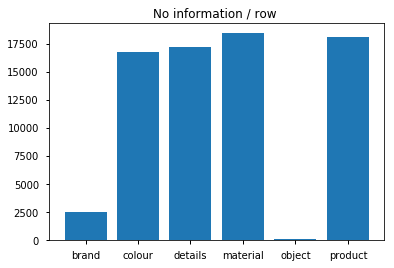

In [152]:
plt.bar(range(len(nul_infos)), list(nul_infos.values()), align='center')
plt.xticks(range(len(nul_infos)), list(nul_infos.keys()))
plt.title("No information / row ")

In [13]:
print("The mean leanght of sentences = {} character".format(int(reader.titleNormalized.map(lambda x:len(x)).sum()/reader.shape[0])))

The mean leanght of sentences = 54 character


## Supprimer les stops words

### Import NLTK Library

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/zarriame/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
stop_words = set(stopwords.words('french'))

In [16]:
helpd = []
for i in range(len(reader.titleNormalized)):
    print("chargement {} %".format(100*i/len(reader.titleNormalized)) )
    helpd.append(" ".join([i.lower() for i in wordpunct_tokenize(reader.titleNormalized.iloc[i]) if i.lower() not in stop_words]))
    clear_output(wait=True)
    
reader.titleNormalized = helpd

chargement 99.995 %


In [17]:
# Extract element for each tag
tags = extract_tags(reader,['brand','colour','details','material','object','product'])
tags_data = {x:len(tags[x]) for x in tags}

Text(0.5, 1.0, 'dictionary size / tag')

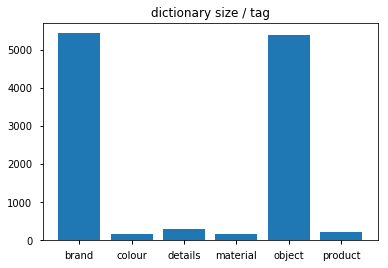

In [153]:
plt.bar(range(len(tags)), list(tags_data.values()), align='center')
plt.xticks(range(len(tags)), list(tags_data.keys()))
plt.title("dictionary size / tag")

#### NB :
<span style="color:red">**Data**</span> : Il y a peu de tags pour 'couleur', 'details', 'materiel' et 'product'. (cela va impacter le process d'apprentissage de RNN => à vérifier )

In [19]:
reader.to_json('processed_data.json',orient='records',lines=True)

## Tagging the texte

In [20]:
reader["tags"] = ["O"]*reader.shape[0]
sub = []
for i in range(reader.shape[0]):
    print("chargement {} %".format(100*i/len(reader.titleNormalized)) )
    result = []
    tags = extract_tags2(reader.iloc[i],['brand','colour','details','material','object','product'])
    for tag in tags:
        if (tags[tag]):
            for element in tags[tag]:
                data = pos_calc(reader.titleNormalized.iloc[i],element,tag)
                sub_result = pos_tag(reader.titleNormalized.iloc[i],data)
                result.append(sub_result)
    sub.append(clean_tags(result))
    clear_output(wait=True)
reader["tags"] = sub

chargement 99.995 %


In [21]:
reader.to_json('tagged_data.json',orient='records',lines=True)

In [22]:
print(" NoteBook take {} minutes".format((time.time()-t)/60))

 NoteBook take 1.9415597836176555 minutes


## Model CRF

### Functions and Libraries

In [80]:
from bs4 import BeautifulSoup as bs
from bs4.element import Tag
import codecs
from sklearn.model_selection import train_test_split
import pycrfsuite
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import itertools
import sklearn_crfsuite
import eli5

In [24]:
def word2feature(doc,i):
	word = doc[i][0]
	postag = doc[i][1]

	feature = [
		'bias',
		'word.lower='+word.lower(),
		'word[-3]='+word[-3:],
		'word[-2]='+word[-2:],
		'word.isupper=%s'%word.isupper(),
		'word.isdigit=%s'%word.isdigit(),
		]

	if i > 0:
		word1 = doc[i-1][0]
		feature.extend([
			'-1:word.lower='+word.lower(),
			'-1:word.isupper=%s'%word.isupper(),
			'-1:word.isdigit=%s'%word.isdigit(),
			])
	else :
		feature.append('BOS')
	
	if i < len(doc)-1:
		word1 = doc[i+1][0]
		feature.extend([
			'+1:word.lower='+word.lower(),
			'+1:word.isupper=%s'%word.isupper(),
			'+1:word.isdigit=%s'%word.isdigit(),
			])
	else :
		feature.append('EOS')

	return feature

In [25]:
def extract_feature(doc):
	return [word2feature(doc,i) for i in range(len(doc))]

def get_labels(doc):
	return [elem[1] for elem in doc]

In [82]:
def model_training(X_train,Y_train,c1,c2,max_iterations,val):
    crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=c1,
    c2=c2,
    max_iterations=max_iterations,
    all_possible_transitions=val,)
    crf.fit(X_train, Y_train);
    return crf

In [28]:
def reverse_tag2(text,tags):
    dic = {'brand':[],'colour':[],'details':[],'material':[],'object':[],'product':[]}
    sequence = text.split(" ")
    insert = ""
    for i in range(len(tags)):
        if (tags[i] == '' or tags[i] == 'O' or tags[i] == 'B'):
            continue
        else:
            sub_tag = tags[i].split("-")
            if(sub_tag[0] == 'B'):
                insert = insert + str(sequence[i])
                if ((i == len(tags)-1)or tags[i+1].split("-")[0] == 'B' or tags[i+1].split("-")[0] == 'O'):
                    dic[sub_tag[1]].append(insert)
                    insert = ""
            elif(sub_tag[0] == 'E'):
                insert = insert + " " +str(sequence[i])
                dic[sub_tag[1]].append(insert)
                insert = ""
            else:
                insert = insert + " "+ str(sequence[i])
    
    return dic

In [29]:
def absolute_score(texts,Y_pred,Y_test):
    results = pd.DataFrame(0, index=np.arange(2), columns=['brand', 'colour', 'details', 'material', 'object', 'product'])
    for i in range(len(texts)):
        dic1 = reverse_tag2(texts.iloc[i],Y_pred[i])
        dic2 = reverse_tag2(texts.iloc[i],Y_test[i])
        for x in dic1:
            true_label = len(set(dic1[x]).intersection(set(dic2[x])))
            false_label = len(set(dic1[x]).difference(set(dic2[x])))
            results[x][0] += true_label
            results[x][1] += false_label
    
    return results

In [61]:
def relative_score(Y_pred,Y_test):
    labels = {'B-brand':0, 'I-brand':1, 'E-brand':2,
          'B-colour':3, 'I-colour':4, 'E-colour':5,
          'B-details':6, 'I-details':7, 'E-details':8,
          'B-material':9, 'I-material':10, 'E-material':11,
          'B-object':12, 'I-object':13, 'E-object':14,
          'B-product':15, 'I-product':16, 'E-product':17,
          'O':18}

    predictionq = []
    truth       = []
    
    for row in Y_pred:
        for tag in row:
            if(tag in labels):
                predictionq.append(labels[tag])
            else:
                predictionq.append(18)
                
    for row in Y_test:
        for tag in row:
            if(tag in labels):
                truth.append(labels[tag])
            else:
                truth.append(18)

    print(classification_report(truth,predictionq))
    
    return classification_report(truth,predictionq,output_dict=True)

### Reading processed data (Extract feature and labels)

In [98]:
reader = pd.read_json('tagged_data.json',lines=True)

### Random train test split evaluation

In [99]:
data_train = reader.tags.sample(frac=0.7)
data_test  = reader.tags.drop(data_train.index.values)
print("training data shape = {} examples".format(data_train.shape[0]))
print("testing data shape = {} examples".format(data_test.shape[0]))

training data shape = 14000 examples
testing data shape = 6000 examples


In [100]:
X_train = [extract_feature(doc) for doc in data_train]
Y_train = [get_labels(doc) for doc in data_train]
X_test  = [extract_feature(doc) for doc in data_test]
Y_test  = [get_labels(doc) for doc in data_test]

In [101]:
model = model_training(X_train,Y_train,0.1,0.01,200,True)

In [106]:
eli5.show_weights(crf)

From \ To,B,O,B-brand,E-brand,I-brand,B-colour,E-colour,B-details,E-details,B-material,E-material,B-object,E-object,I-object,B-product,E-product,I-product
B,-0.018,-0.526,-0.147,-0.031,-0.019,-0.033,-0.018,-0.028,-0.018,-0.023,-0.018,-0.135,-0.02,-0.024,-0.025,-0.021,-0.018
O,-0.468,2.656,2.126,-2.398,-0.74,1.59,-0.505,1.871,-0.482,1.645,-0.495,2.484,-3.104,-2.036,0.027,-1.756,-0.552
B-brand,-0.185,1.443,1.121,4.057,1.717,0.056,-0.203,-0.913,-0.185,-1.193,-0.195,1.496,-2.633,-1.734,-0.484,-1.655,-0.267
E-brand,-0.031,1.926,-0.804,-0.237,-0.056,-0.767,-0.034,-0.447,-0.031,-0.447,-0.033,2.227,-0.614,-0.366,-0.421,-0.317,-0.042
I-brand,-0.019,-1.624,-0.572,3.164,0.541,-0.207,-0.019,-0.117,-0.019,-0.123,-0.019,-0.436,-0.091,-0.051,-0.081,-0.039,-0.022
B-colour,-0.033,-0.11,-0.034,-0.429,-0.132,0.339,1.626,0.265,-0.032,-0.03,-0.034,-0.708,-0.663,-0.393,0.578,-0.35,-0.056
E-colour,-0.018,0.004,0.032,-0.033,-0.019,0.043,-0.019,0.002,-0.018,-0.009,-0.019,-0.146,-0.039,-0.025,-0.026,-0.022,-0.019
B-details,-0.028,0.404,0.665,-0.359,-0.092,0.805,-0.031,0.877,0.115,0.036,-0.029,-0.514,-0.588,-0.331,-0.435,-0.295,-0.045
E-details,-0.018,-0.483,-0.117,-0.031,-0.019,-0.033,-0.018,-0.012,-0.018,-0.023,-0.018,-0.136,-0.037,-0.024,-0.025,-0.021,-0.019
B-material,-0.023,-0.075,-0.431,-0.196,-0.068,0.643,-0.026,-0.112,-0.023,0.81,1.09,-0.417,-0.372,-0.241,-0.315,-0.204,-0.04


In [107]:
Y_pred = model.predict(X_test)

In [109]:
score = relative_score(Y_pred,Y_test)

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      8895
           1       0.67      0.47      0.55        73
           2       0.76      0.64      0.69       852
           3       0.69      0.69      0.69      1055
           5       0.47      0.68      0.56        38
           6       0.80      0.67      0.73       892
           8       0.67      0.50      0.57         4
           9       0.62      0.66      0.64       424
          11       0.74      0.77      0.76        22
          12       0.83      0.80      0.81      5631
          13       0.65      0.56      0.60       505
          14       0.68      0.59      0.63      1134
          15       0.88      0.79      0.83       675
          16       0.84      0.65      0.73        48
          17       0.84      0.81      0.82       385
          18       0.89      0.92      0.91     30236

   micro avg       0.87      0.87      0.87     50869
   macro avg       0.75   

In [110]:
display(absolute_score(reader.titleNormalized.iloc[data_test.index.values],Y_pred,Y_test))

,brand,colour,details,material,object,product
0,5686,696,591,271,4133,492
1,1036,337,144,168,1206,93


### Driven train test split evaluation

#### Selecting specefic tags to predict

<span style="color:red">**brand**</span> = {panasonic, nature, papermania,paslode ...} <br>
<span style="color:green">**colour**</span> = {vert, gris ...} <br>
<span style="color:blue">**object**</span> = {batterie,pates ....}

In [154]:
brand   = ['panasonic', 'nature', 'papermania', 'paslode','packard bell','parade','parisax pro','paul penders','petlas','scorpion','subtel',
          'intermec','samsung','sony','philips','canon','xda'] # 17 elements
colour  = ['vert', 'gris'] # 2 elements
objects = ['batterie', 'pates','chargeur','z2','adaptateur','cable video'] # 6 elements
details = []
material = []
product = []

def select_item(df):
    idx_brand   = []
    idx_colour  = []
    idx_objects = []
    idx_details = []
    idx_material= []
    idx_product = []
    
    for i in range(df.shape[0]):
        #print(  (pd.Series(list(set(brand).intersection(set(df['brand'].iloc[i]))))).values)
        if( isinstance(df['brand'].iloc[i],list)  and list(set(brand).intersection(set(df['brand'].iloc[i])))):
            idx_brand.append(i)
        
        if( isinstance(df['colour'].iloc[i],list)  and list(set(brand).intersection(set(df['colour'].iloc[i])))):
            idx_colour.append(i)
        
        if( isinstance(df['object'].iloc[i],list)  and list(set(brand).intersection(set(df['object'].iloc[i])))):
            idx_objects.append(i)
            
        if( isinstance(df['details'].iloc[i],list)  and list(set(details).intersection(set(df['details'].iloc[i])))):
            idx_details.append(i)
            
        if( isinstance(df['material'].iloc[i],list)  and list(set(material).intersection(set(df['material'].iloc[i])))):
            idx_material.append(i)
            
        if( isinstance(df['product'].iloc[i],list)  and list(set(product).intersection(set(df['product'].iloc[i])))):
            idx_product.append(i)
                
    return list(itertools.chain(idx_brand, idx_colour, idx_objects,idx_details,idx_material,idx_product))

In [112]:
index_drop = select_item(reader)

In [113]:
data_train = reader.tags.drop(index_drop)
data_test  = reader.tags.iloc[index_drop]
print("training data shape = {} examples".format(data_train.shape[0]))
print("testing data shape = {} examples".format(data_test.shape[0]))

training data shape = 17537 examples
testing data shape = 2463 examples


In [114]:
X_train = [extract_feature(doc) for doc in data_train]
Y_train = [get_labels(doc) for doc in data_train]
X_test  = [extract_feature(doc) for doc in data_test]
Y_test  = [get_labels(doc) for doc in data_test]

In [115]:
model = model_training(X_train,Y_train,0.1,0.01,200,True)

In [116]:
eli5.show_weights(crf, top=19)

From \ To,B,O,B-brand,E-brand,I-brand,B-colour,E-colour,B-details,E-details,B-material,E-material,B-object,E-object,I-object,B-product,E-product,I-product
B,-0.018,-0.526,-0.147,-0.031,-0.019,-0.033,-0.018,-0.028,-0.018,-0.023,-0.018,-0.135,-0.02,-0.024,-0.025,-0.021,-0.018
O,-0.468,2.656,2.126,-2.398,-0.74,1.59,-0.505,1.871,-0.482,1.645,-0.495,2.484,-3.104,-2.036,0.027,-1.756,-0.552
B-brand,-0.185,1.443,1.121,4.057,1.717,0.056,-0.203,-0.913,-0.185,-1.193,-0.195,1.496,-2.633,-1.734,-0.484,-1.655,-0.267
E-brand,-0.031,1.926,-0.804,-0.237,-0.056,-0.767,-0.034,-0.447,-0.031,-0.447,-0.033,2.227,-0.614,-0.366,-0.421,-0.317,-0.042
I-brand,-0.019,-1.624,-0.572,3.164,0.541,-0.207,-0.019,-0.117,-0.019,-0.123,-0.019,-0.436,-0.091,-0.051,-0.081,-0.039,-0.022
B-colour,-0.033,-0.11,-0.034,-0.429,-0.132,0.339,1.626,0.265,-0.032,-0.03,-0.034,-0.708,-0.663,-0.393,0.578,-0.35,-0.056
E-colour,-0.018,0.004,0.032,-0.033,-0.019,0.043,-0.019,0.002,-0.018,-0.009,-0.019,-0.146,-0.039,-0.025,-0.026,-0.022,-0.019
B-details,-0.028,0.404,0.665,-0.359,-0.092,0.805,-0.031,0.877,0.115,0.036,-0.029,-0.514,-0.588,-0.331,-0.435,-0.295,-0.045
E-details,-0.018,-0.483,-0.117,-0.031,-0.019,-0.033,-0.018,-0.012,-0.018,-0.023,-0.018,-0.136,-0.037,-0.024,-0.025,-0.021,-0.019
B-material,-0.023,-0.075,-0.431,-0.196,-0.068,0.643,-0.026,-0.112,-0.023,0.81,1.09,-0.417,-0.372,-0.241,-0.315,-0.204,-0.04


In [117]:
Y_pred = model.predict(X_test)

In [118]:
x = relative_score(Y_pred,Y_test)

              precision    recall  f1-score   support

           0       0.95      0.42      0.59      4501
           2       0.69      0.77      0.73        99
           3       0.92      0.64      0.75       396
           5       0.87      1.00      0.93        58
           6       0.74      0.13      0.23       523
           9       0.75      0.33      0.46        18
          12       0.87      0.92      0.89      2335
          13       0.39      0.35      0.37        34
          14       0.60      0.50      0.55       173
          15       0.23      0.62      0.33       319
          16       0.43      0.38      0.40        24
          17       0.63      0.65      0.64       213
          18       0.78      0.95      0.85     10626

   micro avg       0.78      0.78      0.78     19319
   macro avg       0.68      0.59      0.59     19319
weighted avg       0.82      0.78      0.76     19319



In [119]:
display(absolute_score(reader.titleNormalized.iloc[data_test.index.values],Y_pred,Y_test))

,brand,colour,details,material,object,product
0,1748,243,70,6,2089,175
1,138,32,24,2,391,614


### Parameters Tuning 

In [124]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

0.7785599668719914

In [127]:
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}
f1_scorer = make_scorer(metrics.flat_f1_score, average='micro')

In [131]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)

In [137]:
rs = RandomizedSearchCV(crf, params_space, 
                        n_iter=3, 
                        scoring=f1_scorer)
rs.fit(X_train, Y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=None, c2=None,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error...e,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False),
          fit_params=None, iid='warn', n_iter=3, n_jobs=None,
          param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3ad1a3d080>, 'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3ad1a3f6a0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(flat_f1_score, average=micro), verbose=0)

In [138]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.568299171436557, 'c2': 0.00469662891307036}
best CV score: 0.8548599649762038
model size: 1.98M


In [145]:
rs.cv_results_['mean_score_time']

array([0.47089434, 0.46484661, 0.49886513])

In [146]:
crf = rs.best_estimator_
Y_pred = crf.predict(X_test)

In [149]:
eli5.show_weights(crf, top=19)

From \ To,B,O,B-brand,E-brand,I-brand,B-colour,E-colour,B-details,E-details,B-material,E-material,B-object,E-object,I-object,B-product,E-product,I-product
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.308,0.0,0.0,0.0,0.0
O,0.0,2.043,1.021,-4.03,-4.501,0.936,-2.833,1.642,-3.469,0.677,-1.313,1.528,-4.866,-4.644,0.069,-3.236,-1.147
B-brand,0.0,0.476,0.187,4.095,1.063,0.296,-1.673,0.647,-1.601,-0.373,-0.5,0.944,-4.855,-3.265,-0.402,-5.639,-5.002
E-brand,0.0,0.412,-0.447,0.898,-1.332,-1.851,-0.106,0.112,0.0,-1.229,0.0,1.163,-3.033,-2.545,-1.003,-1.105,0.0
I-brand,0.0,-4.839,-3.84,6.258,3.042,-2.27,0.0,-0.763,0.0,-0.766,0.0,-3.103,-0.3,0.0,0.0,0.0,0.0
B-colour,0.0,0.117,-0.099,-2.526,-2.226,-0.157,2.658,1.281,0.0,-0.14,-0.931,-0.04,-2.839,-2.655,0.431,-1.178,-0.515
E-colour,0.0,0.2,0.801,0.0,0.0,0.0,0.0,0.052,0.0,-0.016,0.0,-0.851,0.0,0.0,-0.266,0.0,0.0
B-details,0.0,0.038,0.256,-0.552,-1.331,0.38,-0.959,2.031,3.772,0.005,0.0,-0.068,-2.507,-1.892,-1.408,-0.22,0.0
E-details,0.0,-0.185,0.334,0.0,0.0,0.0,0.0,1.457,0.0,-0.0,0.0,-0.717,0.0,0.0,0.0,0.0,0.0
B-material,0.0,0.161,0.27,0.0,-1.035,0.0,-1.068,0.531,0.0,0.219,4.292,-0.287,-2.414,-1.531,-1.978,-1.076,0.0


In [147]:
x = relative_score(Y_pred,Y_test)

              precision    recall  f1-score   support

           0       0.97      0.53      0.68      4501
           2       0.70      0.70      0.70        99
           3       0.92      0.65      0.76       396
           5       0.87      1.00      0.93        58
           6       0.74      0.09      0.16       523
           9       0.75      0.33      0.46        18
          12       0.87      0.93      0.90      2335
          13       0.56      0.44      0.49        34
          14       0.81      0.51      0.63       173
          15       0.28      0.64      0.38       319
          16       0.36      0.42      0.38        24
          17       0.56      0.68      0.61       213
          18       0.80      0.95      0.87     10626

   micro avg       0.81      0.81      0.81     19319
   macro avg       0.70      0.61      0.61     19319
weighted avg       0.83      0.81      0.79     19319



In [148]:
display(absolute_score(reader.titleNormalized.iloc[data_test.index.values],Y_pred,Y_test))

,brand,colour,details,material,object,product
0,2229,249,48,6,2121,182
1,118,31,17,2,375,465


### Conclusion 1

**Default params**
<img src="pics/default_params.png"> <br>
**Tuned params**
<img src="pics/tuned_params.png"> <br>
**Glossaire**
<img src="pics/default_tags.png" alt="Forest">
<img src="pics/tuned_tags.png" alt="Snow">